In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import backtrader as bt
from datetime import datetime
from rl_trading.strategy.strategy import MovingAverageCrossoverStrategy, RandomStrategy

class AllInSizer(bt.Sizer):
    def _getsizing(self, comminfo, cash, data, isbuy):
        if isbuy:
            # Get commission and slippage info
            commission_info = self.broker.getcommissioninfo(data)
            commission_rate = commission_info.p.commission
            slippage_perc = self.broker.p.slip_perc

            # Estimate transaction cost and slippage
            price = data.close[0]
            gross_cost = cash / price
            commission = commission_rate * gross_cost
            slippage = slippage_perc * price

            # Adjust size to account for estimated commission and slippage
            net_cash = cash - (commission + slippage * gross_cost)
            size = net_cash / price
            return size
        else:
            # For selling, return the size of the current position
            return self.broker.getposition(data).size

# Instantiate Cerebro engine
cerebro = bt.Cerebro()

# Add data feed
df = pd.read_hdf('../data/binance_ohlcv.h5').iloc[-10000:]

data = bt.feeds.PandasData(dataname=df)

cerebro.adddata(data)

# Add strategy
cerebro.addstrategy(MovingAverageCrossoverStrategy)
cerebro.addstrategy(RandomStrategy)

# Add sizer
cerebro.addsizer(AllInSizer)

# Set broker parameters
cerebro.broker.set_cash(10000)
cerebro.broker.setcommission(commission=0.001)  # 0.1% of the operation value
cerebro.broker.set_slippage_perc(0.005)  # 0.5% slippage

# Run the backtest
results = cerebro.run()

# Plot the results
cerebro.plot(width=20, height=12, tight=True, iplot=False)
plt.tight_layout()

In [ ]:
results[0]

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import ray
import warnings
import os
import logging

import matplotlib.pyplot as plt
import pandas as pd
import backtrader as bt
from datetime import datetime
from rl_trading.strategy.strategy import *
from rl_trading.strategy.sizer import AllInSizer
from rl_trading.strategy.analyzers import RelativeQuoteAnalyzer, TradeCountAnalyzer
from tqdm import tqdm

def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

def run_and_plot_strategy(strategy, data, pred_path):
    cerebro = bt.Cerebro()
    if issubclass(strategy, RLStrategy):
        cerebro.addstrategy(strategy, pred_path=pred_path)
    else:
        cerebro.addstrategy(strategy)
    cerebro.adddata(data)
    cerebro.broker.set_cash(10000)
    cerebro.broker.setcommission(commission=0.0001)
    cerebro.broker.set_slippage_perc(0.0)
    cerebro.addsizer(AllInSizer)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe_ratio', riskfreerate=0.0, timeframe=bt.TimeFrame.Minutes)
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(RelativeQuoteAnalyzer, _name='relative_quote')
    cerebro.addanalyzer(TradeCountAnalyzer, _name='trade_count')
    
    results = cerebro.run()
    # fig = cerebro.plot(width=20, height=12, tight=True, iplot=True)[0][0]
    # fig.savefig(f'strategy_plots/{strategy.__name__}.png')
    # plt.close()
    return results[0]
    
# Assuming df is your DataFrame with data
df = pd.read_hdf('../data/binance_ohlcv.h5').loc[pd.to_datetime('2023-06-01'):pd.to_datetime('2023-11-01')]

results = {}
metrics = {}

eval_months = ['june', 'july', 'august', 'september', 'october']

pbar = tqdm(eval_months, desc='Generating predictions', position=0)
for month in pbar:
    metrics[month] = {}
    rl_preds = pd.read_csv(f'../data/dqn_preds/rl_preds_{month}.csv', index_col=0)
    rl_preds.index = pd.to_datetime(rl_preds.index)
    last_timestamp = rl_preds.index[-1]
    data = bt.feeds.PandasData(dataname=df.loc[last_timestamp - pd.Timedelta(days=30) + pd.Timedelta(minutes=1): last_timestamp])
    for strategy in [RandomStrategy, BuyAndHoldStrategy, MeanReversionStrategy, MovingAverageCrossoverStrategy, VolatilityAdjustedDMAC, BollingerBandsStrategy, ARIMAStrategy, RLStrategy]:    
        pbar.set_description(f'Evaluating strategy: {strategy.__name__}')
        if issubclass(strategy, RLStrategy): 
            for model in ['dqn', 'ppo', 'sac', 'r2d2']:
                metrics[month][f'{strategy.__name__}_{model}'] = {}
                if f'{strategy.__name__}_{model}' not in results:
                    results[f'{strategy.__name__}_{model}'] = []
                result = run_and_plot_strategy(strategy, data, f'../data/{model}_preds/rl_preds_{month}.csv')
                metrics[month][f'{strategy.__name__}_{model}']['relative_quote'] = result.analyzers.relative_quote.get_analysis()['relative_quote']
                metrics[month][f'{strategy.__name__}_{model}']['drawdown'] = result.analyzers.drawdown.get_analysis()['drawdown']
                metrics[month][f'{strategy.__name__}_{model}']['sharpe_ratio'] = result.analyzers.sharpe_ratio.get_analysis()['sharperatio']
                metrics[month][f'{strategy.__name__}_{model}']['trade_count'] = result.analyzers.trade_count.get_analysis()['trade_count']
                result_df = pd.DataFrame(result.data_log)
                results[f'{strategy.__name__}_{model}'].append(result_df)
        else:
            metrics[month][strategy.__name__] = {}
            if strategy.__name__ not in results:
                results[strategy.__name__] = []
            result = run_and_plot_strategy(strategy, data, '')
            metrics[month][strategy.__name__]['relative_quote'] = result.analyzers.relative_quote.get_analysis()['relative_quote']
            metrics[month][strategy.__name__]['drawdown'] = result.analyzers.drawdown.get_analysis()['drawdown']
            metrics[month][strategy.__name__]['sharpe_ratio'] = result.analyzers.sharpe_ratio.get_analysis()['sharperatio']
            metrics[month][strategy.__name__]['trade_count'] = result.analyzers.trade_count.get_analysis()['trade_count']
            result_df = pd.DataFrame(result.data_log)
            results[strategy.__name__].append(result_df)
        # plt.plot(result_df['datetime'], result_df['value'], label=f'{strategy.__name__}')
    plt.figure(figsize=(8, 5))
    for i, (strategy, result_dfs) in enumerate(results.items()):
        concat_df = result_dfs[-1]
        # plt.fill_between(concat_df.index, concat_df['q25'], concat_df['q75'], alpha=0.4, color=f'C{i}')
        plt.plot(concat_df['value'], color=f'C{i}', label=f'{strategy}')
    plt.title(f'{month}')
    plt.legend()
    plt.savefig(f'strategy_plots/strategy_comparison_{month}.png')

plt.figure(figsize=(8, 5))
for i, (strategy, result_dfs) in enumerate(results.items()):
    concat_df = pd.concat(result_dfs)
    concat_df = concat_df.groupby(concat_df.index)['value'].agg(['mean', 'min', 'max', q25, q75])
    
    # plt.fill_between(concat_df.index, concat_df['min'], concat_df['max'], alpha=0.2, color=f'C{i}')
    plt.fill_between(concat_df.index, concat_df['q25'], concat_df['q75'], alpha=0.4, color=f'C{i}')
    plt.plot(concat_df['mean'], color=f'C{i}', label=f'{strategy}')
plt.legend()

# plt.xlabel('Date')
# plt.xticks(rotation=45)
# plt.ylabel('Portfolio Value')
# plt.title('Strategy Performance Comparison')
# plt.legend()
# plt.tight_layout()
# plt.savefig('strategy_plots/strategy_performance_comparison.png')

In [69]:
import pickle
with open('results.pkl', 'wb') as file:
    pickle.dump(results, file)

In [70]:
with open('metrics.pkl', 'wb') as file:
    pickle.dump(metrics, file)

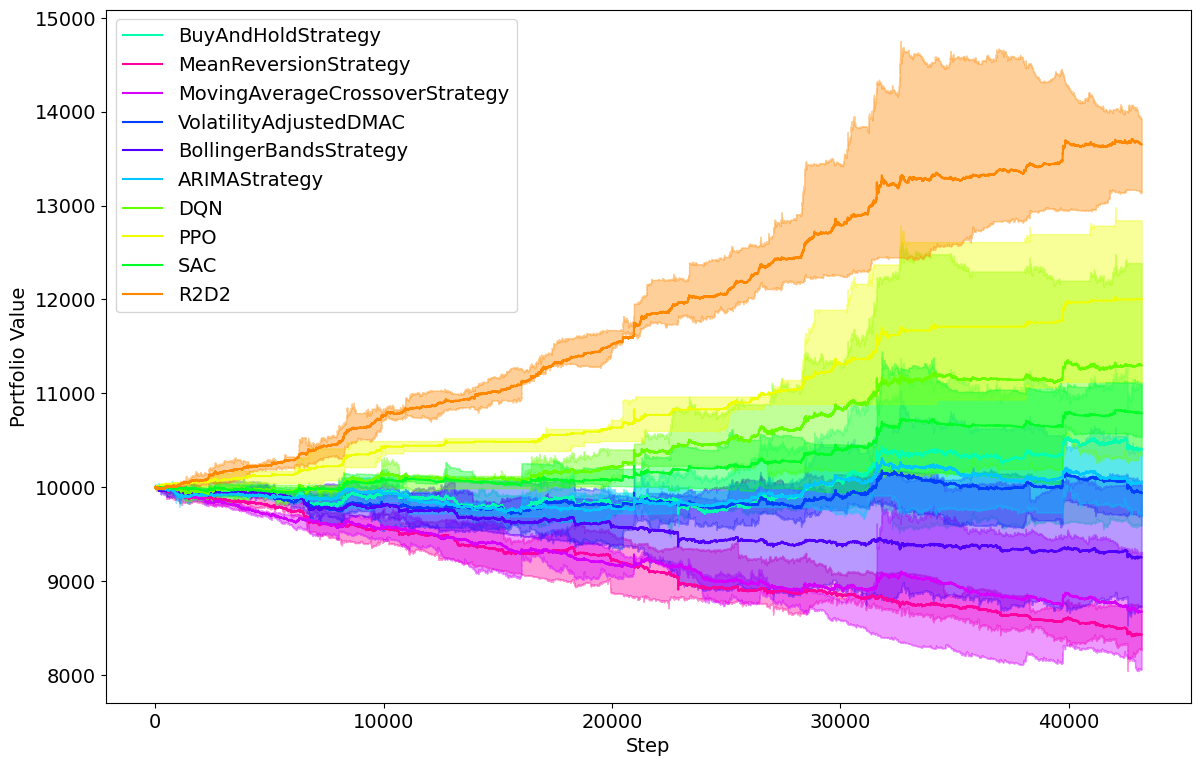

In [59]:
def q33(x):
    return x.quantile(0.33)

def q66(x):
    return x.quantile(0.66)

plt.figure(figsize=(14, 9))
for i, (strategy, result_dfs) in enumerate(results.items()):
    if strategy == 'RandomStrategy':
        continue
    concat_df = pd.concat(result_dfs)
    concat_df = concat_df.groupby(concat_df.index)['value'].agg(['mean', 'min', 'max', q33, q66])
    
    # plt.fill_between(concat_df.index, concat_df['min'], concat_df['max'], alpha=0.2, color=f'C{i}')
    if 'RLStrategy' not in strategy:
        plt.fill_between(concat_df.index, concat_df['q33'], concat_df['q66'], alpha=0.4, color=color_mapping[strategy])
        plt.plot(concat_df['mean'], label=f'{strategy}', color=color_mapping[strategy])
    else:
        plt.fill_between(concat_df.index, concat_df['q33'], concat_df['q66'], alpha=0.4, color=color_mapping[strategy.split("_")[-1].upper()])
        plt.plot(concat_df['mean'], label=f'{strategy.split("_")[-1].upper()}', color=color_mapping[strategy.split("_")[-1].upper()])
    plt.xlabel('Step', fontsize=14)
    plt.ylabel('Portfolio Value', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
plt.legend(fontsize=14)
plt.savefig('strategy_plots/strategy_performance_comparison.png')
plt.savefig('strategy_plots/strategy_performance_comparison.pdf')
plt.show()
plt.close()

In [92]:
import pickle

with open('results.pkl', 'rb') as file:
    results = pickle.load(file)
    
with open('metrics.pkl', 'rb') as file:
    metrics = pickle.load(file)

In [93]:
import pandas as pd
import numpy as np
import backtrader as bt
from collections import defaultdict

def rename_strategy(x):
    if 'RLStrategy' in x:
        return x.split('_')[-1].upper()
    else:
        return x

risk_free_rate_annual = 0.005

# Convert annual risk-free rate to monthly rate
trading_days = 30  # Approximate number of trading days in a month
trading_minutes = trading_days * 24 * 60  # Number of trading minutes in a month
risk_free_rate_monthly = (1 + risk_free_rate_annual) ** (1 / 12) - 1

annualized_sharpe_ratio = defaultdict(dict)
months = ['june', 'july', 'august','september', 'october']
for month in months:
    for i, (strategy, result_dfs) in enumerate(results.items()):
        strategy_name = rename_strategy(strategy)
        res_df = result_dfs[months.index(month)].copy()
        
        # Calculate portfolio returns (minute by minute returns)
        res_df['portfolio_return'] = res_df['value'].pct_change()
        
        # Calculate excess returns
        res_df['excess_return'] = res_df['portfolio_return'] - (risk_free_rate_monthly / trading_minutes)
        
        # Calculate the standard deviation of excess returns (volatility)
        excess_return_std = res_df['excess_return'].std()
        
        # Calculate monthly Sharpe Ratio
        sharpe_ratio_monthly = res_df['excess_return'].mean() / excess_return_std
        
        # Annualize the Sharpe Ratio
        sharpe_ratio_annualized = sharpe_ratio_monthly * np.sqrt(trading_minutes)
        
        annualized_sharpe_ratio[month][strategy_name] = sharpe_ratio_annualized
        
        print(f"{month} {strategy}: {sharpe_ratio_annualized:.4f}")

june RandomStrategy: -15.8586
june BuyAndHoldStrategy: 0.9866
june MeanReversionStrategy: -2.3370
june MovingAverageCrossoverStrategy: -0.2774
june VolatilityAdjustedDMAC: -0.8729
june BollingerBandsStrategy: -1.6790
june ARIMAStrategy: 0.5799
june RLStrategy_dqn: 2.6143
june RLStrategy_ppo: 4.7497
june RLStrategy_sac: 3.0558
june RLStrategy_r2d2: 5.2905
july RandomStrategy: -24.1781
july BuyAndHoldStrategy: -0.5084
july MeanReversionStrategy: -3.0639
july MovingAverageCrossoverStrategy: -3.9192
july VolatilityAdjustedDMAC: 0.1518
july BollingerBandsStrategy: -1.7287
july ARIMAStrategy: -1.5269
july RLStrategy_dqn: 0.2968
july RLStrategy_ppo: 3.4200
july RLStrategy_sac: -0.1325
july RLStrategy_r2d2: 5.8808
august RandomStrategy: -19.5730
august BuyAndHoldStrategy: -1.2377
august MeanReversionStrategy: -3.6522
august MovingAverageCrossoverStrategy: -3.7407
august VolatilityAdjustedDMAC: -0.3852
august BollingerBandsStrategy: -2.4817
august ARIMAStrategy: -0.6141
august RLStrategy_dqn: 0

In [95]:
flattened_metrics = []
for month in metrics:
    for strategy in metrics[month]:
        for metric_name, metric_value in metrics[month][strategy].items():
            if metric_name == 'sharpe_ratio':
                strategy_name = rename_strategy(strategy)
                flattened_metrics.append((month, strategy, metric_name, annualized_sharpe_ratio[month][strategy_name]))
            else:
                flattened_metrics.append((month, strategy, metric_name, metric_value))
            
df = pd.DataFrame(flattened_metrics, columns=['month', 'strategy', 'metric_name', 'value'])
df

,month,strategy,metric_name,value
0,june,RandomStrategy,relative_quote,2984.685191
1,june,RandomStrategy,drawdown,70.224299
2,june,RandomStrategy,sharpe_ratio,-15.858636
3,june,RandomStrategy,trade_count,7137.000000
4,june,BuyAndHoldStrategy,relative_quote,11076.736356
...,...,...,...,...
215,october,RLStrategy_sac,trade_count,865.000000
216,october,RLStrategy_r2d2,relative_quote,13904.195196
217,october,RLStrategy_r2d2,drawdown,10.272815
218,october,RLStrategy_r2d2,sharpe_ratio,3.762517


In [96]:
import seaborn as sns

adf = df.groupby(['strategy', 'metric_name']).agg({'value': 'mean'})
adf

value
strategy                       metric_name                 
ARIMAStrategy                  drawdown            5.229450
                               relative_quote  10046.375075
                               sharpe_ratio       -0.087569
                               trade_count        66.400000
BollingerBandsStrategy         drawdown            9.289373
                               relative_quote   9254.263499
                               sharpe_ratio       -1.084732
                               trade_count       459.200000
BuyAndHoldStrategy             drawdown            5.146484
                               relative_quote  10403.195523
                               sharpe_ratio        0.275665
                               trade_count         0.000000
MeanReversionStrategy          drawdown           16.198289
                               relative_quote   8430.292317
                               sharpe_ratio       -2.496416
                               trade_count       886.400000
MovingAverageCrossoverStrategy drawdown           14.605699
                               relative_quote   8673.116037
                               sharpe_ratio       -2.554396
                               trade_count       863.400000
RLStrategy_dqn                 drawdown            2.038207
                               relative_quote  11296.287197
                               sharpe_ratio        1.424178
                               trade_count        11.800000
RLStrategy_ppo                 drawdown            0.542696
                               relative_quote  12003.128365
                               sharpe_ratio        3.827265
                               trade_count        19.400000
RLStrategy_r2d2                drawdown            2.596149
                               relative_quote  13651.604498
                               sharpe_ratio        5.389373
                               trade_count       908.200000
RLStrategy_sac                 drawdown            2.000764
                               relative_quote  10791.101757
                               sharpe_ratio        1.421445
                               trade_count       650.200000
RandomStrategy                 drawdown           71.812742
                               relative_quote   2823.037285
                               sharpe_ratio      -19.515337
                               trade_count      7212.400000
VolatilityAdjustedDMAC         drawdown            5.688242
                               relative_quote   9938.909237
                               sharpe_ratio       -0.153418
                               trade_count       142.600000

In [97]:
adf_unstacked = adf.unstack(level='metric_name')
adf_unstacked.columns = adf_unstacked.columns.get_level_values(1)

# Optionally, rename the columns for clarity
adf_unstacked = adf_unstacked.rename(columns=lambda x: x.replace('Metric', 'Value'))
adf_unstacked

metric_name,drawdown,relative_quote,sharpe_ratio,trade_count
strategy,,,,
ARIMAStrategy,5.229450,10046.375075,-0.087569,66.4
BollingerBandsStrategy,9.289373,9254.263499,-1.084732,459.2
BuyAndHoldStrategy,5.146484,10403.195523,0.275665,0.0
MeanReversionStrategy,16.198289,8430.292317,-2.496416,886.4
MovingAverageCrossoverStrategy,14.605699,8673.116037,-2.554396,863.4
RLStrategy_dqn,2.038207,11296.287197,1.424178,11.8
RLStrategy_ppo,0.542696,12003.128365,3.827265,19.4
RLStrategy_r2d2,2.596149,13651.604498,5.389373,908.2
RLStrategy_sac,2.000764,10791.101757,1.421445,650.2


In [98]:
df = adf_unstacked.reset_index()

In [99]:
def rename_strategy(x):
    if 'RLStrategy' in x:
        return x.split('_')[-1].upper()
    else:
        return x
    
df['strategy'] = df['strategy'].apply(rename_strategy)
df.index.name = 'index'
df.reset_index(inplace=True)
df.drop(columns='index', inplace=True)
df = df[['strategy', 'relative_quote', 'drawdown','sharpe_ratio', 'trade_count']]
df.sort_values(by='relative_quote', ascending=False, inplace=True)
df['relative_quote'] /= 10_000
df['relative_quote'] -= 1
df['relative_quote'] *= 100
df['trade_count'] += 1
df['sharpe_ratio'] = df['sharpe_ratio'].round(4)
df['relative_quote'] = df['relative_quote'].round(2)
df['drawdown'] = df['drawdown'].round(2)

In [52]:
print(df.to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
strategy & relative_quote & drawdown & sharpe_ratio & trade_count \\
\midrule
R2D2 & 36.520000 & 2.600000 & 5.389400 & 909.200000 \\
PPO & 20.030000 & 0.540000 & 3.827300 & 20.400000 \\
DQN & 12.960000 & 2.040000 & 1.424200 & 12.800000 \\
SAC & 7.910000 & 2.000000 & 1.421400 & 651.200000 \\
BuyAndHoldStrategy & 4.030000 & 5.150000 & 0.275700 & 1.000000 \\
ARIMAStrategy & 0.460000 & 5.230000 & -0.087600 & 67.400000 \\
VolatilityAdjustedDMAC & -0.610000 & 5.690000 & -0.153400 & 143.600000 \\
BollingerBandsStrategy & -7.460000 & 9.290000 & -1.084700 & 460.200000 \\
MovingAverageCrossoverStrategy & -13.270000 & 14.610000 & -2.554400 & 864.400000 \\
MeanReversionStrategy & -15.700000 & 16.200000 & -2.496400 & 887.400000 \\
RandomStrategy & -71.770000 & 71.810000 & -19.515300 & 7213.400000 \\
\bottomrule
\end{tabular}


\begin{tabular}{lrrrr}
\toprule
strategy & drawdown & relative_quote & sharpe_ratio & trade_count \\
\midrule
R2D2 & 2.600000 & -101.000000 & 5.389400 & 911.200000 \\
PPO & 0.540000 & -101.000000 & 3.827300 & 22.400000 \\
DQN & 2.040000 & -101.000000 & 1.424200 & 14.800000 \\
SAC & 2.000000 & -101.000000 & 1.421400 & 653.200000 \\
BuyAndHoldStrategy & 5.150000 & -101.000000 & 0.275700 & 3.000000 \\
ARIMAStrategy & 5.230000 & -101.000000 & -0.087600 & 69.400000 \\
VolatilityAdjustedDMAC & 5.690000 & -101.000000 & -0.153400 & 145.600000 \\
BollingerBandsStrategy & 9.290000 & -101.000000 & -1.084700 & 462.200000 \\
MovingAverageCrossoverStrategy & 14.610000 & -101.000000 & -2.554400 & 866.400000 \\
MeanReversionStrategy & 16.200000 & -101.000000 & -2.496400 & 889.400000 \\
RandomStrategy & 71.810000 & -101.010000 & -19.515300 & 7215.400000 \\
\bottomrule
\end{tabular}


In [89]:
df

,relative_quote,drawdown,sharpe_ratio,trade_count
strategy,,,,
R2D2,39.04,10.27,3.7625,1670.0
PPO,35.54,1.11,3.5267,26.0
DQN,27.60,1.70,2.2938,9.0
BuyAndHoldStrategy,21.33,1.42,1.6509,1.0
SAC,11.11,3.20,1.3404,866.0
VolatilityAdjustedDMAC,8.53,3.93,0.8772,156.0
ARIMAStrategy,7.90,7.00,0.8943,125.0
BollingerBandsStrategy,2.90,2.02,0.4187,451.0
MovingAverageCrossoverStrategy,-6.90,8.22,-0.7074,872.0


In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = df[df['strategy'] != 'RandomStrategy']

/tmp/ipykernel_925778/458753066.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(new_labels)


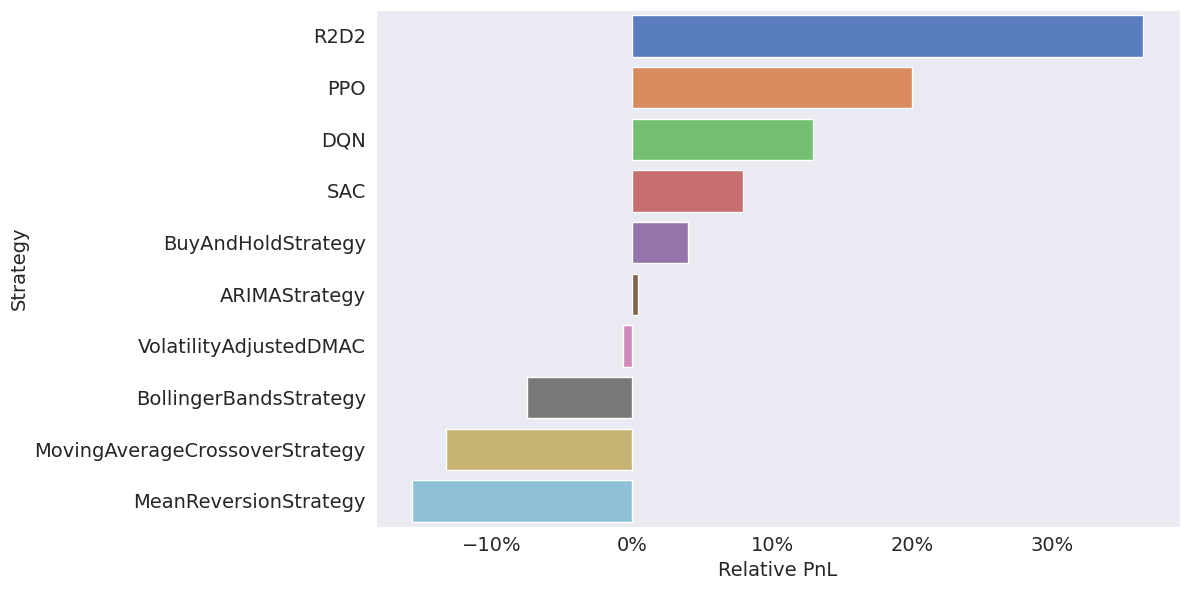

In [101]:
df = df.sort_values(by='relative_quote', ascending=False)
algorithms = df['strategy'].unique()

palette = sns.color_palette('muted', n_colors=len(algorithms))

color_mapping = dict(zip(algorithms, palette))

colors = df['strategy'].map(color_mapping)
plt.figure(figsize=(12, 6))
sns.barplot(df, y='strategy', x='relative_quote', palette=colors)

labels = [item.get_text() for item in plt.gca().get_xticklabels()]
new_labels = [label + '%' for label in labels]

plt.gca().set_xticklabels(new_labels)
plt.xlabel('Relative PnL', fontsize=14)
plt.ylabel('Strategy', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.savefig('strategy_plots/strategy_relative_quote.png')
plt.savefig('strategy_plots/strategy_relative_quote.pdf')
plt.show()
plt.close()

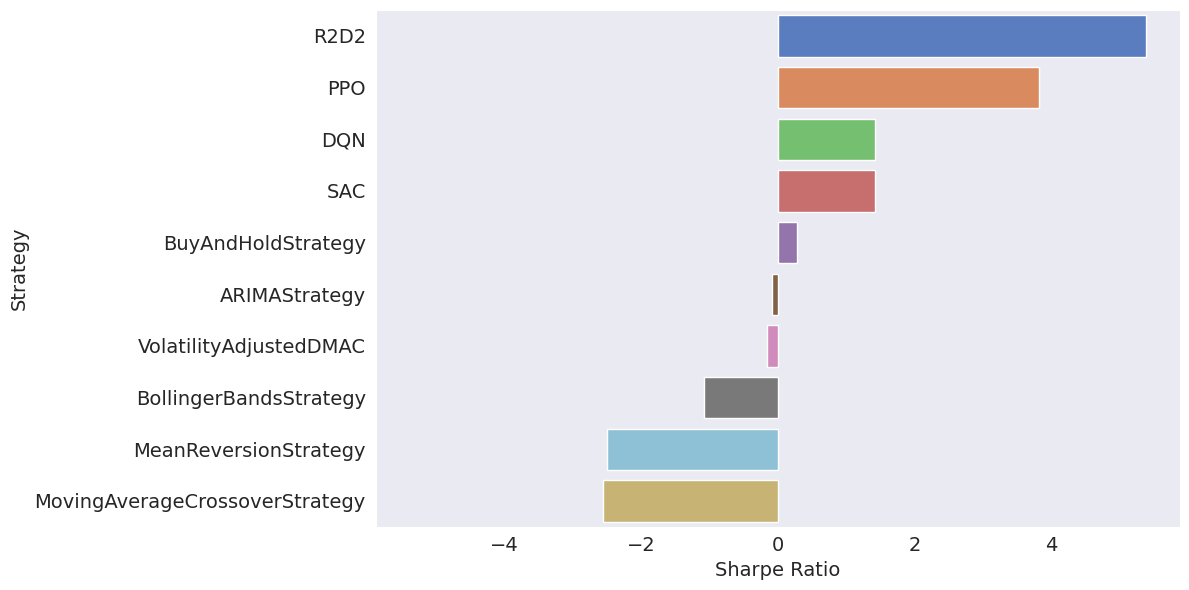

In [60]:
df = df.sort_values(by='sharpe_ratio', ascending=False)

colors = df['strategy'].map(color_mapping)
plt.figure(figsize=(12, 6))
sns.barplot(df, y='strategy', x='sharpe_ratio', palette=colors)
plt.xlabel('Sharpe Ratio', fontsize=14)
plt.ylabel('Strategy', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
plt.xlim(-df['sharpe_ratio'].abs().max() - 0.5, df['sharpe_ratio'].abs().max() + 0.5)
plt.tight_layout()
plt.savefig('strategy_plots/strategy_sharpe_ratio.png')
plt.savefig('strategy_plots/strategy_sharpe_ratio.pdf')
plt.show()
plt.close()

/tmp/ipykernel_925778/2209715646.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(new_labels)


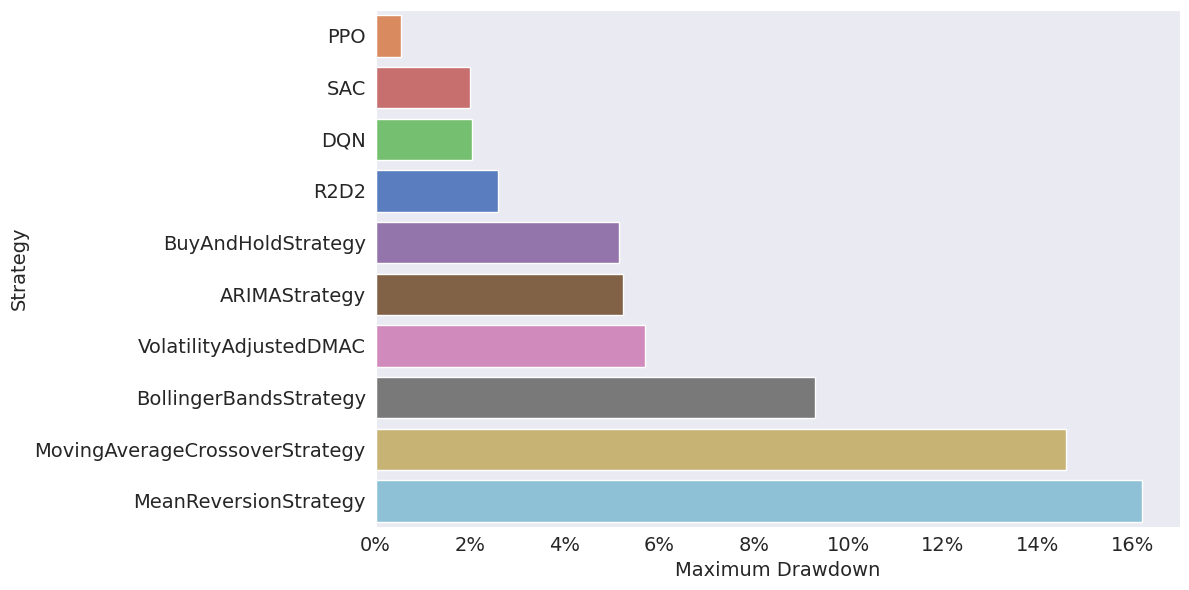

In [63]:
df = df.sort_values(by='drawdown', ascending=True)
colors = df['strategy'].map(color_mapping)
plt.figure(figsize=(12, 6))
sns.barplot(df, y='strategy', x='drawdown', palette=colors)

labels = [item.get_text() for item in plt.gca().get_xticklabels()]
new_labels = [label + '%' for label in labels]

plt.gca().set_xticklabels(new_labels)
plt.xlabel('Maximum Drawdown', fontsize=14)
plt.ylabel('Strategy', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.savefig('strategy_plots/strategy_drawdown.png')
plt.savefig('strategy_plots/strategy_drawdown.pdf')
plt.show()
plt.close()

/tmp/ipykernel_925778/1341063300.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(new_labels)


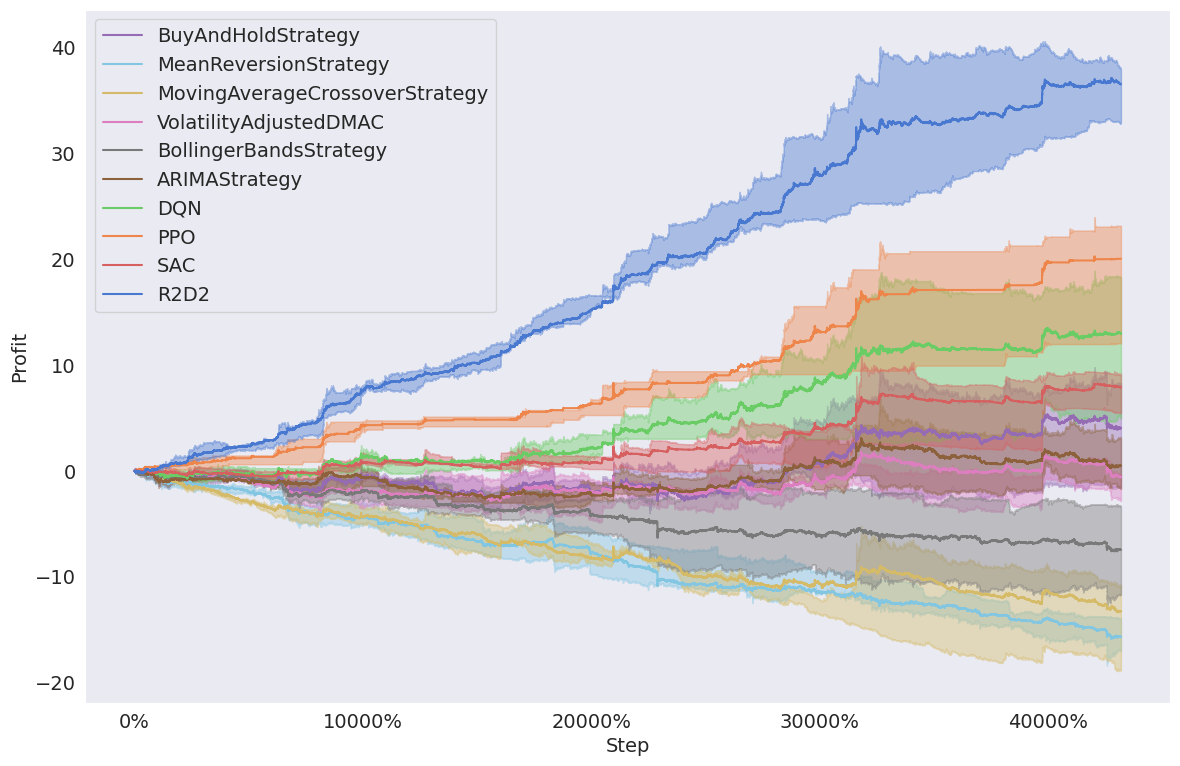

In [104]:
def q33(x):
    return x.quantile(0.33)

def q66(x):
    return x.quantile(0.66)

plt.figure(figsize=(14, 9))
for i, (strategy, result_dfs) in enumerate(results.items()):
    if strategy == 'RandomStrategy':
        continue
    concat_df = pd.concat(result_dfs)
    concat_df['value'] /= 10_000
    concat_df['value'] -= 1
    concat_df['value'] *= 100
    concat_df = concat_df.groupby(concat_df.index)['value'].agg(['mean', 'min', 'max', q33, q66])
    
    # plt.fill_between(concat_df.index, concat_df['min'], concat_df['max'], alpha=0.2, color=f'C{i}')
    if 'RLStrategy' not in strategy:
        plt.fill_between(concat_df.index, concat_df['q33'], concat_df['q66'], alpha=0.4, color=color_mapping[strategy])
        plt.plot(concat_df['mean'], label=f'{strategy}', color=color_mapping[strategy])
    else:
        plt.fill_between(concat_df.index, concat_df['q33'], concat_df['q66'], alpha=0.4, color=color_mapping[strategy.split("_")[-1].upper()])
        plt.plot(concat_df['mean'], label=f'{strategy.split("_")[-1].upper()}', color=color_mapping[strategy.split("_")[-1].upper()])

labels = [item.get_text() for item in plt.gca().get_xticklabels()]
new_labels = [label + '%' for label in labels]

plt.gca().set_xticklabels(new_labels)
plt.xlabel('Step', fontsize=14)
plt.ylabel('Profit', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
plt.legend(fontsize=14)
plt.savefig('strategy_plots/strategy_performance_comparison.png')
plt.savefig('strategy_plots/strategy_performance_comparison.pdf')
plt.show()
plt.close()

In [69]:
metrics['october']

{'RandomStrategy': {'relative_quote': 3048.7141203880556,
  'drawdown': 69.51285879611945,
  'sharpe_ratio': -0.07058479711124019,
  'trade_count': 7288},
 'BuyAndHoldStrategy': {'relative_quote': 12132.76866559515,
  'drawdown': 1.4235788421291813,
  'sharpe_ratio': 0.007959574688977964,
  'trade_count': 0},
 'MeanReversionStrategy': {'relative_quote': 9295.108279495886,
  'drawdown': 8.333234721070564,
  'sharpe_ratio': -0.0044272335107119355,
  'trade_count': 900},
 'MovingAverageCrossoverStrategy': {'relative_quote': 9309.650472572128,
  'drawdown': 8.217844857101703,
  'sharpe_ratio': -0.0033823438248613206,
  'trade_count': 871},
 'VolatilityAdjustedDMAC': {'relative_quote': 10852.96208796785,
  'drawdown': 3.9258716517134404,
  'sharpe_ratio': 0.004240950310412413,
  'trade_count': 155},
 'BollingerBandsStrategy': {'relative_quote': 10289.603497926846,
  'drawdown': 2.020955231328677,
  'sharpe_ratio': 0.002041722668563129,
  'trade_count': 450},
 'ARIMAStrategy': {'relative_quo

In [77]:

sdf

,sharpe_ratio
strategy,
RandomStrategy,-14.675924
BuyAndHoldStrategy,1.650939
MeanReversionStrategy,-0.925633
MovingAverageCrossoverStrategy,-0.707369
VolatilityAdjustedDMAC,0.877238
BollingerBandsStrategy,0.418721
ARIMAStrategy,0.894307
DQN,2.293796
PPO,3.526712


In [88]:
month = 'october'
df = pd.DataFrame(metrics[month]).T
df.index.name = 'strategy'
df.reset_index(inplace=True)

sdf = pd.DataFrame.from_records([(k, v) for k, v in annualized_sharpe_ratio[month].items()])
sdf.columns = ['strategy', 'sharpe_ratio']
sdf.set_index('strategy', inplace=True)

def rename_strategy(x):
    if 'RLStrategy' in x:
        return x.split('_')[-1].upper()
    else:
        return x
    
df['strategy'] = df['strategy'].apply(rename_strategy)
df.set_index('strategy', inplace=True)
df['relative_quote'] /= 10_000
df['relative_quote'] -= 1
df['relative_quote'] *= 100
df.sort_values('relative_quote', ascending=False, inplace=True)
df['trade_count'] += 1
df['sharpe_ratio'] = sdf['sharpe_ratio']
df['sharpe_ratio'] = df['sharpe_ratio'].round(4)
df['relative_quote'] = df['relative_quote'].round(2)
df['drawdown'] = df['drawdown'].round(2)

df['sharpe_ratio']

strategy
R2D2                               3.7625
PPO                                3.5267
DQN                                2.2938
BuyAndHoldStrategy                 1.6509
SAC                                1.3404
VolatilityAdjustedDMAC             0.8772
ARIMAStrategy                      0.8943
BollingerBandsStrategy             0.4187
MovingAverageCrossoverStrategy    -0.7074
MeanReversionStrategy             -0.9256
RandomStrategy                   -14.6759
Name: sharpe_ratio, dtype: float64

In [81]:
df

,relative_quote,drawdown,sharpe_ratio,trade_count
strategy,,,,
R2D2,39.04,10.27,3.762517,1670.0
PPO,35.54,1.11,3.526712,26.0
DQN,27.60,1.70,2.293796,9.0
BuyAndHoldStrategy,21.33,1.42,1.650939,1.0
SAC,11.11,3.20,1.340380,866.0
VolatilityAdjustedDMAC,8.53,3.93,0.877238,156.0
ARIMAStrategy,7.90,7.00,0.894307,125.0
BollingerBandsStrategy,2.90,2.02,0.418721,451.0
MovingAverageCrossoverStrategy,-6.90,8.22,-0.707369,872.0


/tmp/ipykernel_32246/993522150.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(new_labels)
/tmp/ipykernel_32246/993522150.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(new_labels)
/tmp/ipykernel_32246/993522150.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(new_labels)
/tmp/ipykernel_32246/993522150.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(new_labels)
/tmp/ipykernel_32246/993522150.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(new_labels)


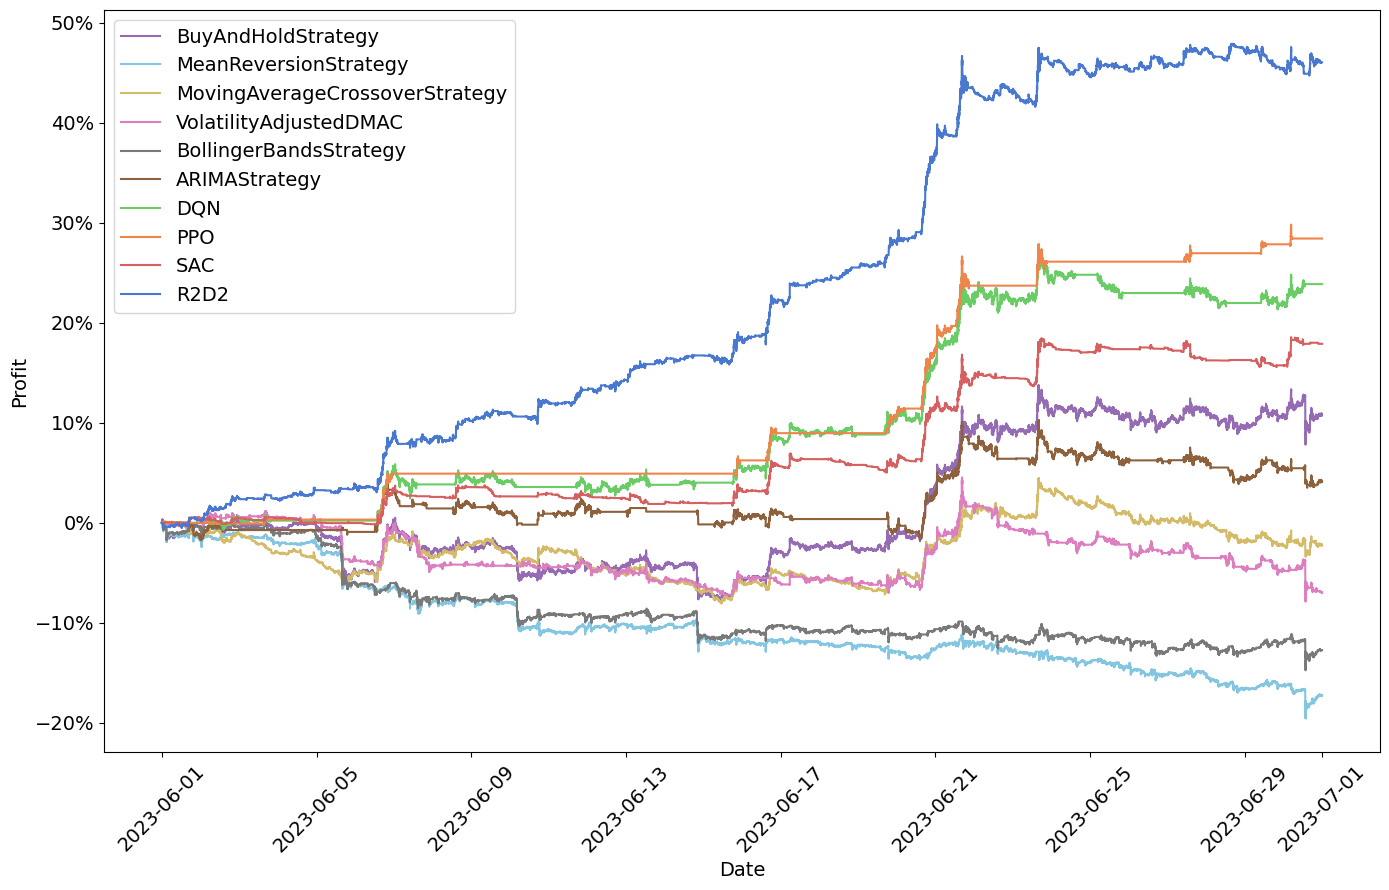

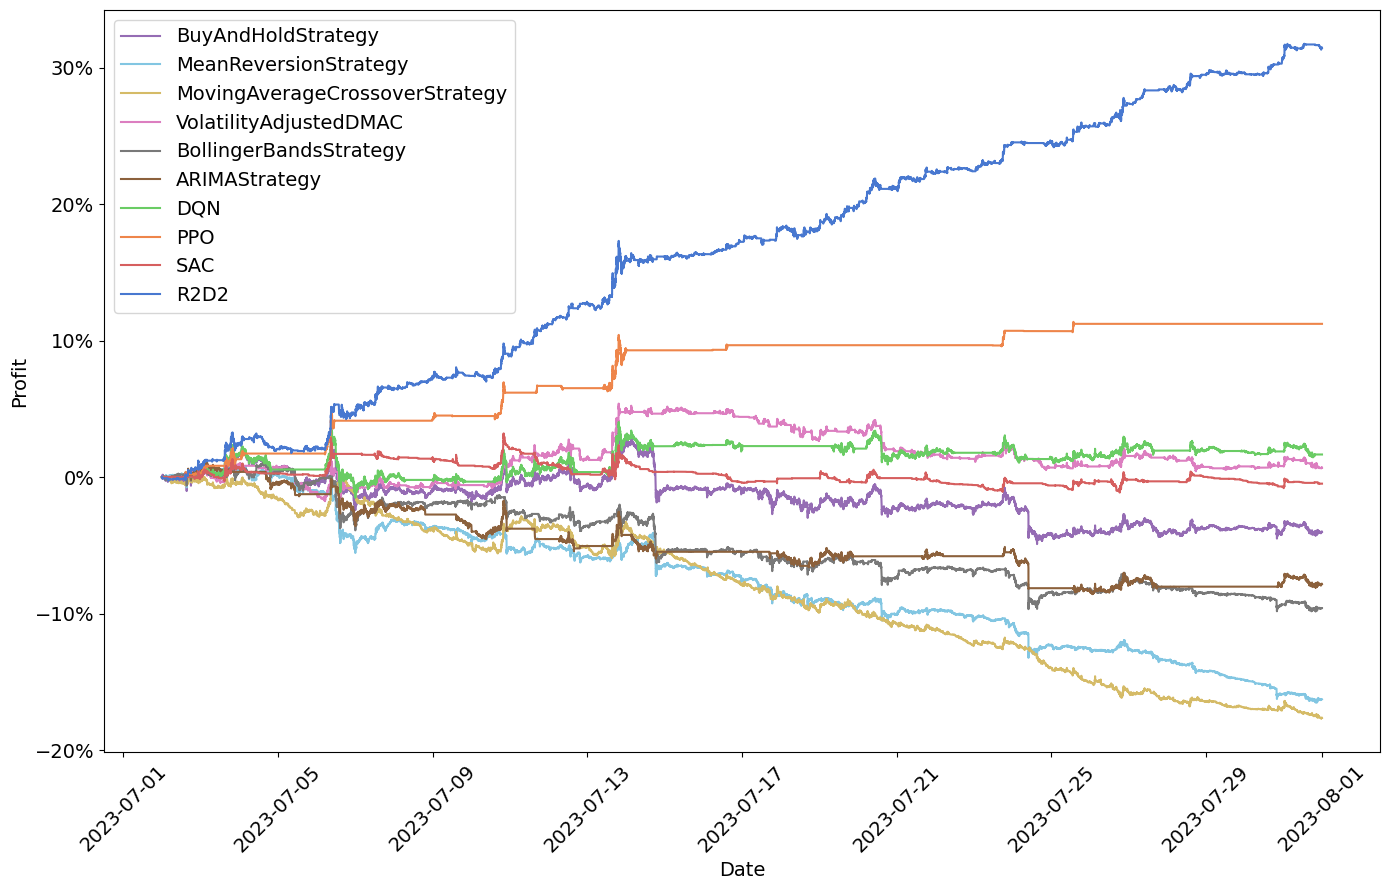

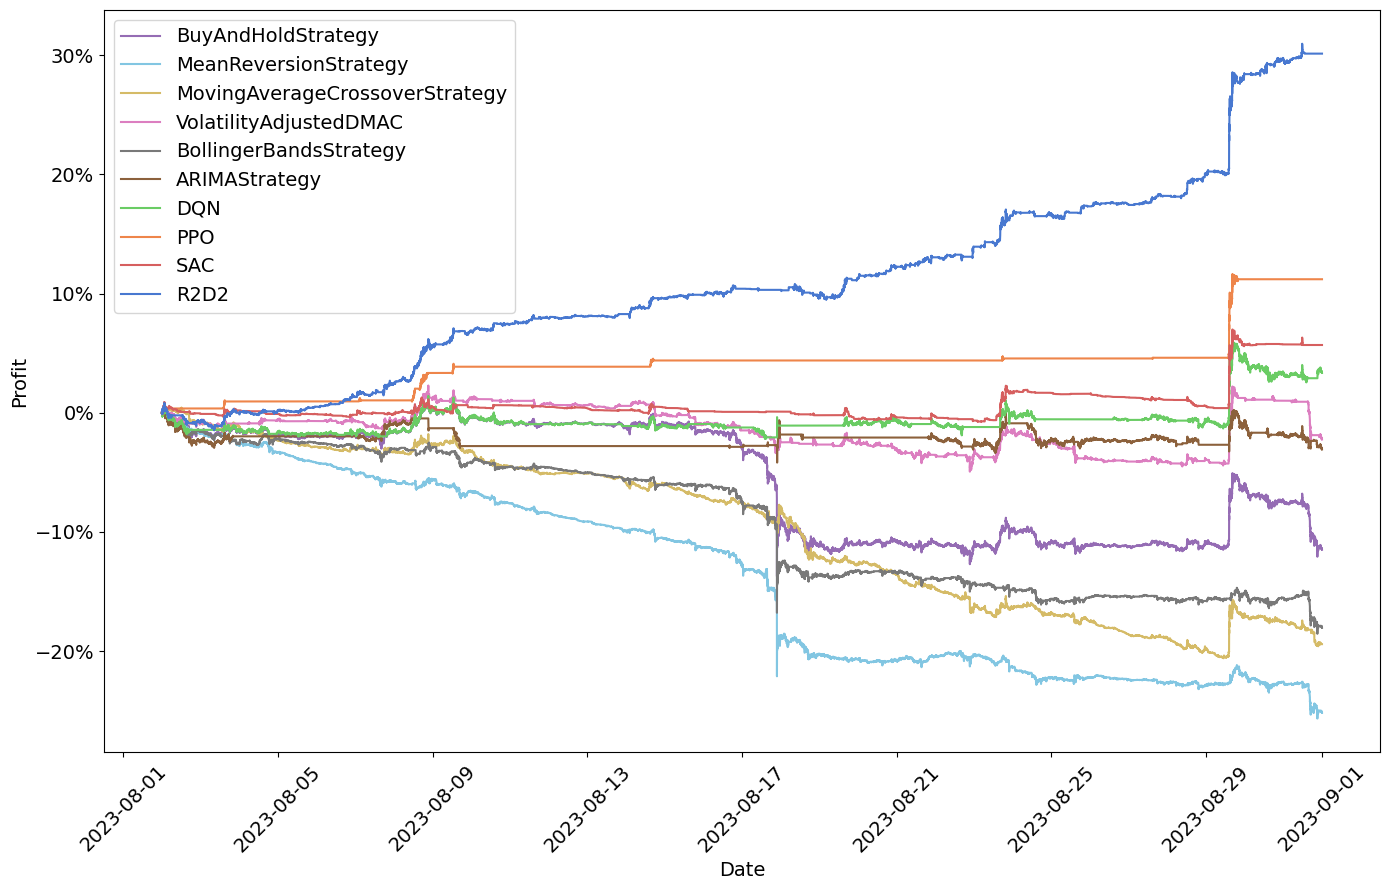

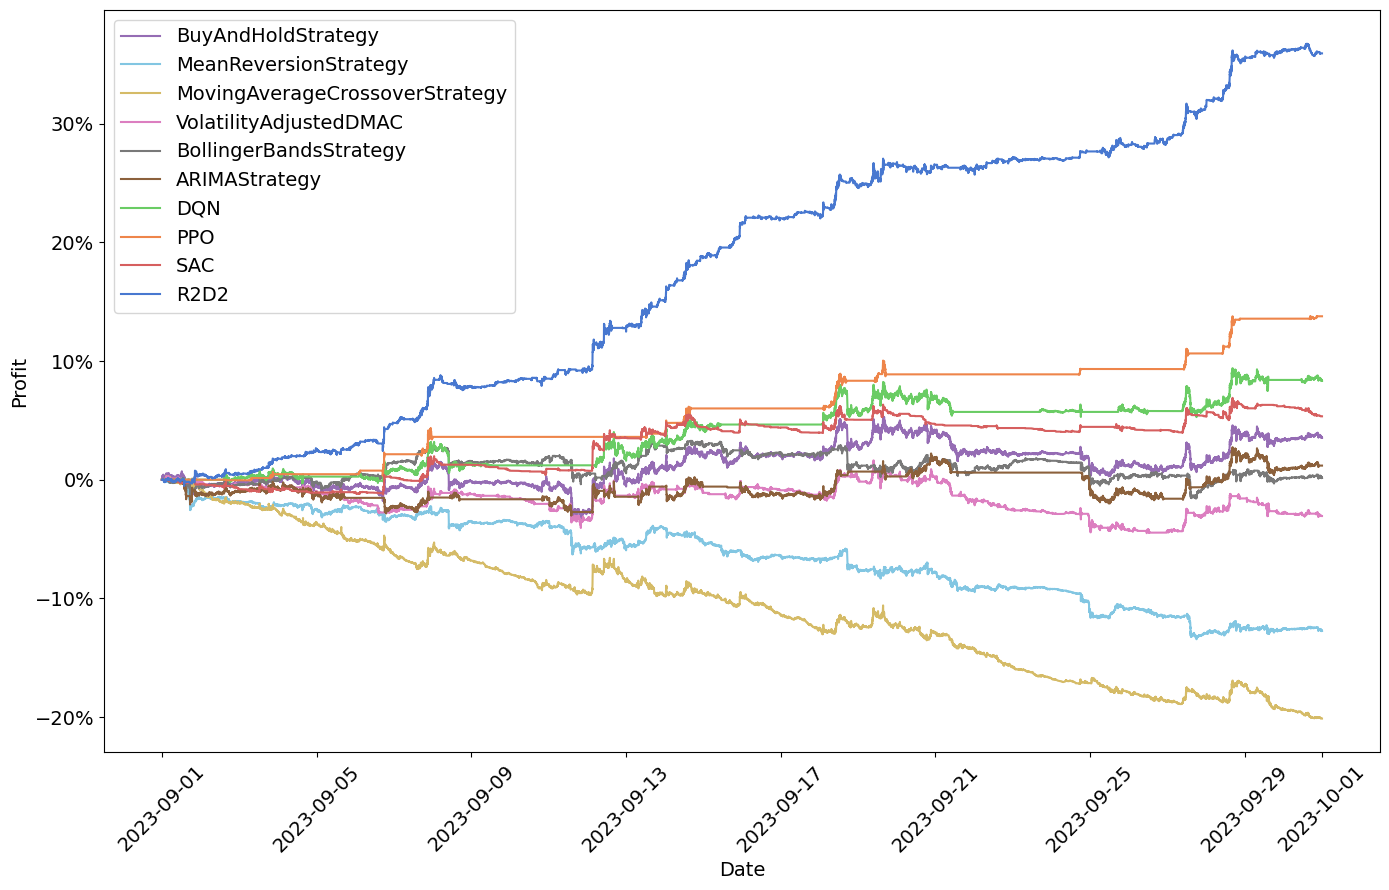

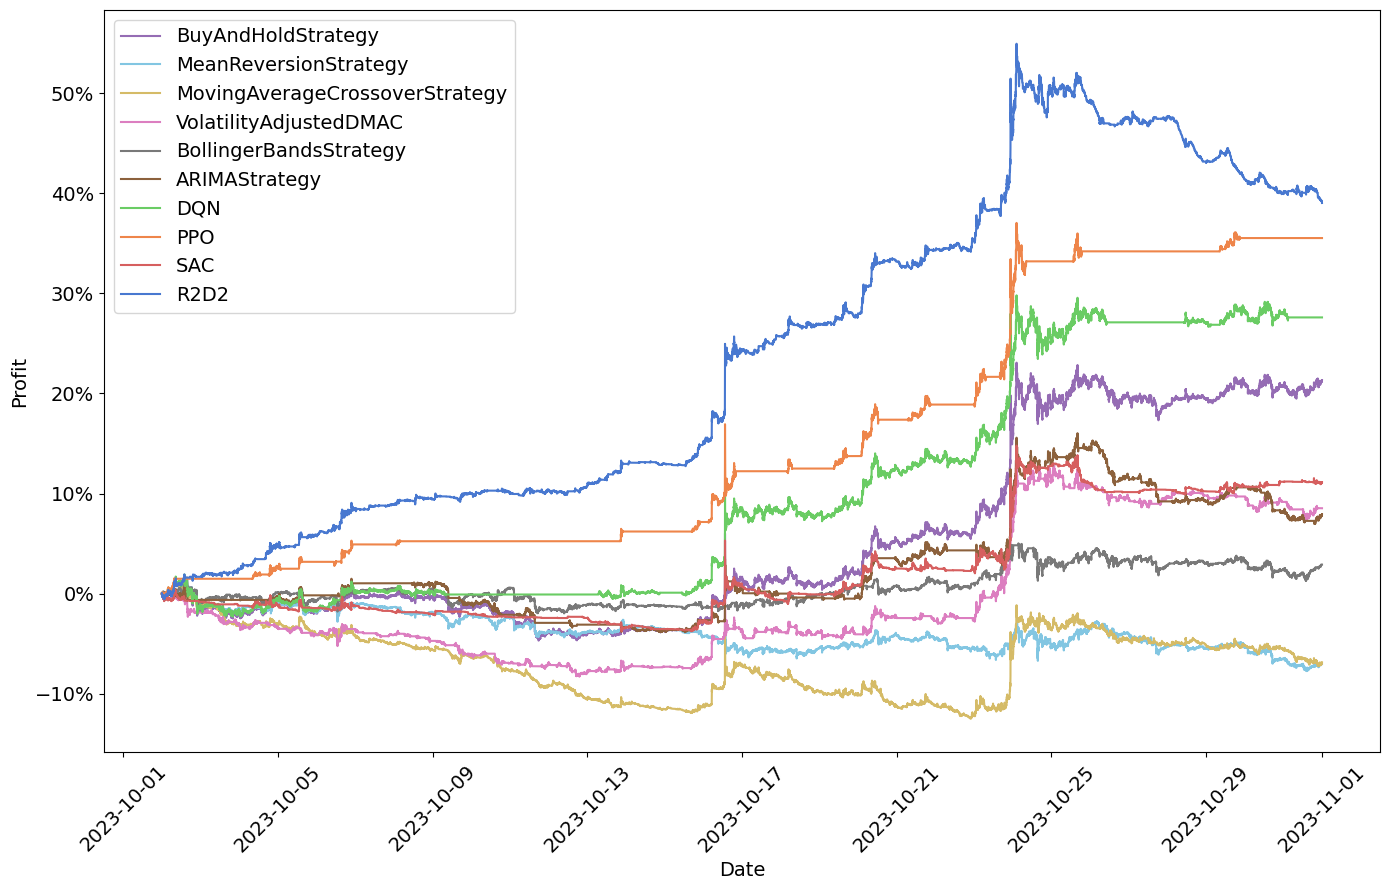

In [118]:
months = ['june', 'july', 'august','september', 'october']
for month in months:
    plt.figure(figsize=(14, 9))
    for i, (strategy, result_dfs) in enumerate(results.items()):
        if strategy == 'RandomStrategy':
            continue
        res_df = result_dfs[months.index(month)].copy()
        res_df.set_index('datetime', inplace=True)
        res_df['value'] /= 10_000
        res_df['value'] -= 1
        res_df['value'] *= 100
        strategy_name = rename_strategy(strategy)
        if 'RLStrategy' in strategy:
            plt.plot(res_df['value'], label=f'{strategy_name}', color=color_mapping[strategy.split("_")[-1].upper()])
        else:
            plt.plot(res_df['value'], label=f'{strategy_name}', color=color_mapping[strategy])
    labels = [item.get_text() for item in plt.gca().get_yticklabels()]
    new_labels = [label + '%' for label in labels]
    plt.gca().set_yticklabels(new_labels)
    
    plt.legend(fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Profit', fontsize=14)
    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig(f'strategy_plots/strategy_profit_comparison_{month}.png')
    plt.savefig(f'strategy_plots/strategy_profit_comparison_{month}.pdf')

In [ ]:
df = df[df['strategy'] != 'RandomStrategy']


sns.lineplot(x='strategy', y='relative_quote', hue='strategy', data=)

In [5]:
import pickle
with open('eval_results.pkl', 'wb') as file:
    pickle.dump(results, file)

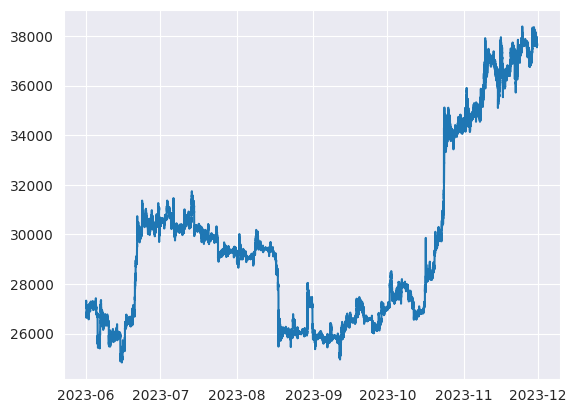

In [6]:
plt.plot(df1.loc[pd.to_datetime('2023-06-01'):]['price'])

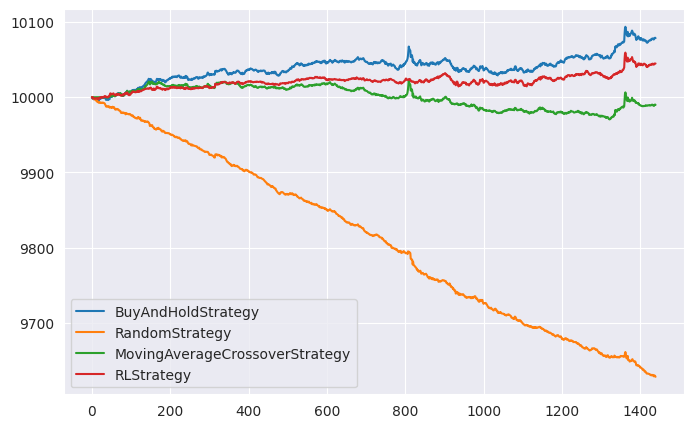

In [3]:
plt.figure(figsize=(8, 5))
for i, (strategy, result_dfs) in enumerate(results.items()):
    concat_df = pd.concat(result_dfs)
    concat_df = concat_df.groupby(concat_df.index)['value'].agg(['mean', 'min', 'max', q25, q75])
    
    # plt.fill_between(concat_df.index, concat_df['min'], concat_df['max'], alpha=0.2, color=f'C{i}')
    # plt.fill_between(concat_df.index, concat_df['q25'], concat_df['q75'], alpha=0.4, color=f'C{i}')
    plt.plot(concat_df['mean'], color=f'C{i}', label=f'{strategy}')
    
plt.legend()

In [5]:
results['RLStrategy']

[Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Index: [],
 Empty DataFrame
 Columns: []
 Ind

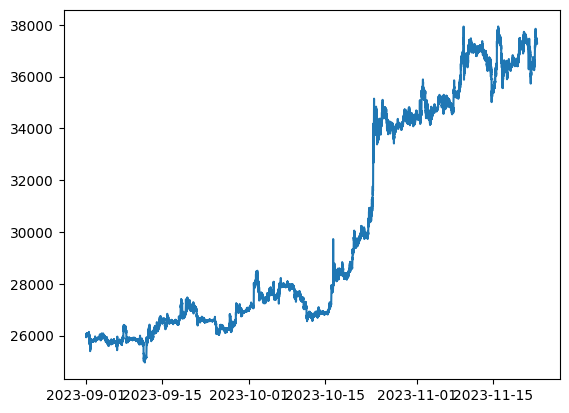

In [55]:
df = pd.read_hdf('../data/binance_ohlcv.h5').loc[pd.to_datetime('2023-09-01'):]
plt.plot((df['open'] + df['close']) / 2)

In [35]:
def agg_trajectory(df):
    df['value_mean'] = df['value'].mean()
    df['value_p25'] = df['value'].quantile(0.25)
    df['value_p75'] = df['value'].quantile(0.75)
    df['value_min'] = 

,datetime,balance,position,value
0,2023-10-01 00:00:00,10000.000000,0.000000,10000.000000
1,2023-10-01 00:01:00,10000.000000,0.000000,10000.000000
2,2023-10-01 00:02:00,990.996992,0.333858,9990.252154
3,2023-10-01 00:03:00,9981.252899,0.000000,9981.252899
4,2023-10-01 00:04:00,9981.252899,0.000000,9981.252899
...,...,...,...,...
1435,2023-10-30 23:55:00,6432.244751,0.000000,6432.244751
1436,2023-10-30 23:56:00,6432.244751,0.000000,6432.244751
1437,2023-10-30 23:57:00,6432.244751,0.000000,6432.244751
1438,2023-10-30 23:58:00,6432.244751,0.000000,6432.244751


In [3]:
import pandas as pd

df = pd.read_hdf('../data/binance_ohlcv.h5').loc[pd.to_datetime('2023-10-01') + pd.Timedelta(minutes=1):pd.to_datetime('2023-10-31')]

In [6]:
df.index[-1].timestamp()

1698710400.0

In [8]:
df2.loc[:1698710400].to_hdf('../data/eval_data.h5', key='data', format='table')

In [7]:
df2 = pd.read_hdf('/home/fassty/Devel/school/diploma_thesis/code/data/binance_BTC_USDT_new.h5')
df2

,amount,price
timestamp,,
1502942460,1.775183,4261.480000
1502942580,0.261074,4280.560000
1502942640,0.012008,4261.480000
1502942700,0.140796,4261.480000
1502943480,0.075455,4262.187216
...,...,...
1700406000,33.372000,36441.188104
1700406060,21.839630,36455.101213
1700406120,4.700650,36444.464377


## Strategy optimization

In [1]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import backtrader as bt
from itertools import product
from rl_trading.strategy.strategy import ARIMAStrategy
from rl_trading.strategy.sizer import AllInSizer
from rl_trading.strategy.analyzers import RelativeQuoteAnalyzer

cerebro = bt.Cerebro()

param_ranges = dict(
    lookback=[30],
    order=list(product(range(0, 6, 1), range(0, 2, 1), range(0, 2, 1))),
)
total_runs = len(list(product(*param_ranges.values())))
print(f'Optimization will run for {total_runs} runs')

df = pd.read_hdf('../data/binance_ohlcv.h5').loc[pd.to_datetime('2023-05-14'):pd.to_datetime('2023-05-18')]
data = bt.feeds.PandasData(dataname=df)

cerebro.adddata(data)

cerebro.optstrategy(
    ARIMAStrategy,
    **param_ranges
)
cerebro.addsizer(AllInSizer)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe_ratio', riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(RelativeQuoteAnalyzer, _name='relative_quote')

cerebro.broker.set_cash(10000)
cerebro.broker.setcommission(commission=0.0001)
cerebro.broker.set_slippage_perc(0.0)

opt_runs = cerebro.run(maxcpus=4)

max_value = 0
best_params = None
for run in opt_runs:
    for strategy in run:
        relative_quote = strategy.analyzers.relative_quote.get_analysis()['relative_quote']
        if relative_quote > max_value:
            max_value = relative_quote
            best_params = strategy.params  # Access the strategy parameters

print(f"Best Parameters: {best_params}, Final Value: {max_value}")

2023-12-17 12:56:42,725	WARNING __init__.py:10 -- PG has/have been moved to `rllib_contrib` and will no longer be maintained by the RLlib team. You can still use it/them normally inside RLlib util Ray 2.8, but from Ray 2.9 on, all `rllib_contrib` algorithms will no longer be part of the core repo, and will therefore have to be installed separately with pinned dependencies for e.g. ray[rllib] and other packages! See https://github.com/ray-project/ray/tree/master/rllib_contrib#rllib-contrib for more information on the RLlib contrib effort.
2023-12-17 12:56:42,737	WARNING __init__.py:10 -- ApexDQN has/have been moved to `rllib_contrib` and will no longer be maintained by the RLlib team. You can still use it/them normally inside RLlib util Ray 2.8, but from Ray 2.9 on, all `rllib_contrib` algorithms will no longer be part of the core repo, and will therefore have to be installed separately with pinned dependencies for e.g. ray[rllib] and other packages! See https://github.com/ray-project/r

Optimization will run for 24 runs
Final RQ: 9814.033343704004
Final RQ: 10000.0


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Final RQ: 10379.370396210645


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Final RQ: 10331.00839474654
Final RQ: 9744.018761850724


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Final RQ: 9964.634958825705


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Final RQ: 10180.945240681282


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Final RQ: 10061.065028563833


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Final RQ: 10147.812769693268


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Final RQ: 10087.042253632282


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Final RQ: 10148.466872871266


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Final RQ: 10052.960483640103


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Final RQ: 10095.591723849482


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Error fitting ARIMA model: LU decomposition error.


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Final RQ: 10142.994515733188


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Final RQ: 10068.506854899295


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Final RQ: 10302.621425374266


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Final RQ: 10022.336866114727


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Final RQ: 10022.143106268179


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Error fitting ARIMA model: LU decomposition error.


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Final RQ: 10245.711615714257


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Final RQ: 10089.648248299538


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Final RQ: 10030.360877364117


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Error fitting ARIMA model: LU decomposition error.


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Final RQ: 10066.515908575484


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Final RQ: 10036.871399712449


/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/fassty/anaconda3/envs/diploma_thesis/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Final RQ: 9904.13960939704
Best Parameters: <backtrader.metabase.AutoInfoClass_LineRoot_LineMultiple_LineSeries_LineIterator_DataAccessor_StrategyBase_Strategy_BaseStrategy_ARIMAStrategy object at 0x7f93b8f9fca0>, Final Value: 10379.370396210645


In [3]:
best_params
opt_runs

KeyboardInterrupt: 

In [26]:
best_params.__dict__

{'fast1': 7,
 'slow1': 30,
 'fast2': 18,
 'slow2': 49,
 'volatility_period': 14,
 'volatility_threshold': 0.0005}